In [1]:
import pickle
import networkx
import matplotlib.pyplot as plt
import networkx as nx
import geopandas
import momepy
import numpy as np
import pandas as pd
import shapely
from scipy.optimize import LinearConstraint
from road_system_params import *
import importlib
from config import *
from IPython.display import clear_output


/Users/gordonma/PycharmProjects/pythonProject1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("data/nodes", "rb") as fp:  #Unpickling
    nodes = pickle.load(fp)
with open("data/edges", "rb") as fp:  #Unpickling
    edges = pickle.load(fp)
with open("data/traffic_network", "rb") as fp:  #Unpickling
    G = pickle.load(fp)

In [3]:
paths = nx.shortest_path(G, weight = "sim_distance")
sample_size_only = edges[["Edge_ID", "sampleSize","In", "Out"]]
In_rows = sample_size_only.loc[sample_size_only["In"].isin(nodes[nodes["type"] == "inflow" ]["Node_ID"])]
Out_rows = sample_size_only.loc[sample_size_only["Out"].isin(nodes[nodes["type"] == "outflow" ]["Node_ID"])]

In [4]:
In_rows["In_probability"] =  In_rows["sampleSize"]/ In_rows["sampleSize"].sum()
Out_rows["Out_probability"] = Out_rows["sampleSize"] / Out_rows["sampleSize"].sum()
clear_output()

In [5]:
print(In_rows.sort_values(by = "In"),"\n" , Out_rows.sort_values(by = "Out") )

    Edge_ID  sampleSize  In  Out  In_probability
0         0        2352   0    7        0.469461
6         6         692   1    5        0.138124
13       13         994   2    4        0.198403
9         9         972   3    6        0.194012 
     Edge_ID  sampleSize  In  Out  Out_probability
1         1        1677   9   10         0.359948
4         4         760   8   11         0.163125
12       12        1421   6   12         0.305001
11       11         801   4   13         0.171925


We need to design our inflow rates to satisfy these constrains, given the paths below, inorder to match the sample sizes observed in the data collected

In [6]:
possible_paths = []
for i in G.nodes:
    if nodes["type"][i] == "inflow":
        possible_paths += [paths[i][v] for v in nodes[nodes.type == "outflow"].Node_ID]

Compute the transition matrix from node to node given the dataset with the sample size. We assume the sample size is indicative of the probability that the road is travsersed. 

In [7]:
transition_matrix = np.zeros((14,14))
for row in sample_size_only.iterrows():
    row = row[1]
    transition_matrix[row["Out"],row["In"]] = row["sampleSize"] #We want row to be output, and columns to be input
transition_matrix = transition_matrix / ((In_rows["sampleSize"].sum() +  Out_rows["sampleSize"].sum())/2)

Define the Objective function we will try to optimize -- We are finding the transition probability of a vehicle through the system. This can be expressed as a (number of output nodes) x (number of input nodes) matrix. In our case, 4x4. We assume a car will take the shortest path, thus the path from start node to end node is defined. 

In [8]:
def sample_size_function(input_array, *args):
    # Normalize here again so optimization is smoother
    transition_distributions = np.reshape(input_array, (4,4)) / (np.sum(input_array) + 0.00001)

    sample_size_only,transition_matrix,In_rows,Out_rows, paths, return_func_ev  = args
    
    test_transition_matrix = np.zeros(np.shape(transition_matrix))
    
    for j, in_data in enumerate(In_rows.iterrows()):
        for i, out_data in enumerate(Out_rows.iterrows()):
            path_probability = transition_distributions[i,j]
            in_node = in_data[1]["In"]
            out_node = out_data[1]["Out"]
            path = paths[in_node][out_node]

            in_node = path[0]
            for next_node in path[1:]:
                test_transition_matrix[next_node][in_node] += path_probability
                in_node = next_node
    #sum by columns for input probability
    in_differences = (transition_distributions.sum(axis = 1) - In_rows["In_probability"])**2
    #sum by rows for output probability
    out_differences = (transition_distributions.sum(axis = 0) - Out_rows["Out_probability"])**2
    transition_differences = (transition_matrix - test_transition_matrix)**2
    if return_func_ev:
        return(np.sum(0.25*in_differences + 0.25*out_differences) + np.sum(transition_differences) + 
              (0.1*(np.sum(input_array) - 1))**4) #provide a smoother landscape where we have normalization
    else:
        return(test_transition_matrix)

In [9]:
#Toy example showing the transition matrix with uniform entrance and exit probability
np.set_printoptions(linewidth=100)
transmatrix = np.round(sample_size_function(np.ones(16), sample_size_only,transition_matrix,In_rows,Out_rows, paths, False),3)
print(transmatrix)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.25  0.    0.    0.    0.375 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.25  0.    0.    0.375 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.25  0.    0.    0.    0.    0.375 0.    0.    0.    0.    0.   ]
 [0.25  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.375 0.    0.25  0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.25  0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.25  0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   

In [10]:
import scipy.optimize as spopt
probability_bounds = [(0,1)]*16
bounds = probability_bounds
In_rows.sort_values(by = "In", inplace = True)
Out_rows.sort_values(by = "Out", inplace= True) 

/var/folders/p_/g2xgtt_s6d7bs9d7tgmq8nm40000gn/T/ipykernel_69999/2421008082.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  In_rows.sort_values(by = "In", inplace = True)
/var/folders/p_/g2xgtt_s6d7bs9d7tgmq8nm40000gn/T/ipykernel_69999/2421008082.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Out_rows.sort_values(by = "Out", inplace= True)


In [11]:
#Define constraint on the optimization function
A = np.ones((1,16))
#We implemented a soft constraint on the normalization constraint to reduce the search space
lc = LinearConstraint(A,0.9,1.1)

# !!Warning!!
Cell below will take a while to run, use pickled result below

In [14]:
result = spopt.differential_evolution(sample_size_function, bounds = bounds, strategy = "randtobest1bin" , tol = 0.005,
                                      mutation = (0.6,1.5), recombination = 0.75, maxiter = 5000,
                                      popsize = 30, init = 'sobol',
                                      args = (sample_size_only,transition_matrix,In_rows,Out_rows, paths, True),
                                             constraints = lc)
with open("data/optimization_result", "wb") as fp:   #Pickling
    pickle.dump(result, fp)

In [12]:
with open("data/optimization_result", "rb") as fp: #Unpcikling
    result = pickle.load(fp)

In [13]:
result

             message: Optimization terminated successfully.
             success: True
                 fun: 0.008457711349176014
                   x: [ 7.429e-02  1.032e-01 ...  7.788e-02  3.527e-02]
                 nit: 1369
                nfev: 191615
          population: [[ 3.954e-02  9.678e-02 ...  9.859e-02  3.903e-02]
                       [ 4.185e-02  1.015e-01 ...  5.852e-02  5.392e-02]
                       ...
                       [ 3.425e-02  8.113e-02 ...  8.032e-02  2.531e-02]
                       [ 4.737e-02  8.828e-02 ...  7.297e-02  4.592e-02]]
 population_energies: [ 8.458e-03  8.530e-03 ...  8.481e-03  8.555e-03]
              constr: [array([ 0.000e+00])]
    constr_violation: 0.0
               maxcv: 0.0
                 jac: [array([[ 1.000e+00,  1.000e+00, ...,  1.000e+00,
                               1.000e+00]]), array([[ 1.000e+00,  0.000e+00, ...,  0.000e+00,
                               0.000e+00],
                             [ 0.000e+00,  1.

In [14]:
input_array = result.x
normalized_array = np.reshape(input_array, (4,4)) / np.sum(input_array) 
print(normalized_array)

[[0.07029124 0.09762658 0.09777048 0.05502814]
 [0.13511743 0.01797403 0.02053227 0.01503676]
 [0.18324332 0.02337057 0.02504633 0.08820144]
 [0.04859969 0.01509804 0.07369287 0.0333708 ]]


In [15]:
#Resulting Transition Matrix. We assume that the intial array is something like [1,1,1,1] + [0]*10, as the first
#Set of transition probabilities take care of the transition into each individual nodes. 
np.set_printoptions(linewidth=100)
transmatrix = np.round(sample_size_function(normalized_array, sample_size_only,transition_matrix,In_rows,Out_rows, paths, False),3)
print(transmatrix)

[[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.217 0.    0.    0.    0.237 0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.154 0.    0.    0.284 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.192 0.    0.    0.    0.    0.366 0.    0.    0.    0.    0.   ]
 [0.437 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.117 0.    0.437 0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.321 0.    0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    0.    0.    0.321 0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   

Sanity Checks, whether the input and output distribution matches what we were trying to optimize for

In [16]:
normalized_array.sum(axis = 0)

array([0.43725168, 0.15406923, 0.21704195, 0.19163714])

In [17]:
In_rows

,Edge_ID,sampleSize,In,Out,In_probability
0,0,2352,0,7,0.469461
6,6,692,1,5,0.138124
13,13,994,2,4,0.198403
9,9,972,3,6,0.194012


In [18]:
normalized_array.sum(axis = 1)

array([0.32071644, 0.1886605 , 0.31986165, 0.17076141])

In [19]:
Out_rows

,Edge_ID,sampleSize,In,Out,Out_probability
1,1,1677,9,10,0.359948
4,4,760,8,11,0.163125
12,12,1421,6,12,0.305001
11,11,801,4,13,0.171925


In [20]:
entry_data = []
for column in normalized_array.T:
    arrival_probability = np.sum(column)
    path_probs = column / arrival_probability
    entry_data.append([arrival_probability, path_probs])

In [21]:
relative_arrival_rates = pd.DataFrame(entry_data, columns = ["relative_probability", "path_distribution"])

In [22]:
relative_arrival_rates

,relative_probability,path_distribution
0,0.437252,"[0.16075693621308623, 0.30901523876370013, 0.4..."
1,0.154069,"[0.6336539914271151, 0.11666205972212869, 0.15..."
2,0.217042,"[0.45046813728372387, 0.09460047642892215, 0.1..."
3,0.191637,"[0.287147556824675, 0.07846475745315105, 0.460..."


In [26]:
with open("data/relative_arrival_rates", "wb") as fp:   #Pickling
    pickle.dump(relative_arrival_rates, fp)

In [28]:
#Simulation using the optimal parameters
import road_system_params
importlib.reload(road_system_params)
sim = road_system_params.TrafficSystemParameterised()
sim.build_network(edges, nodes, relative_arrival_rates, netflow_rate = 0.8, dpi = 200)
cycle_offsets  = {
    8: 0,
    5: 0,
    6: 18,
    4: 18,
}
for node, offset in cycle_offsets.items():
    sim.traffic_grid.nodes[node]["node"].counter += offset
plt.close()

In [29]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as anim
import numpy as np
from IPython.display import HTML
from tqdm import tqdm
def make_animation(sim, total_frames, steps_per_frame=1, interval=100, title = ''):
    def update(frame_number):
        for _ in range(steps_per_frame):
            sim.update()
        progress_bar.update(1)
        return [sim.draw(title)]

    progress_bar = tqdm(total=total_frames)
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=interval)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output


In [30]:
make_animation(sim, total_frames=300, steps_per_frame=1, title = "Traffic Simulation at Best-Fit Flow Rate")


  0%|          | 0/300 [00:00<?, ?it/s]/Users/gordonma/PycharmProjects/pythonProject1/road_system_params.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.axes.plot([row[0], row[2]], [row[1], row[3]], color="black", zorder = 1)
/Users/gordonma/PycharmProjects/pythonProject1/road_system_params.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.axes.plot([row[0], row[2]], [row[1], row[3]], color="black", zorder = 1)
  1%|          | 3/300 [00:00<00:13, 21.29it/s]/Users/gordonma/PycharmProjects/pythonProject1/road_system_params.py:113: FutureWarning: Series.__getitem__ treating keys as positions is depr

# Finding the Optimal Input Rate

Since we only obtained a probability distribution, we still need the coefficient -- how much cars are flowing into the system per second. We can use a least-squares approach to brute-force the parameter fitting, and obtain some nice data in the process on the system's behavior at various input rates. 

In [31]:
def differences_from_measurement(netflow_rate, *args):
    sim, edges, nodes, relative_arrival_rates = args 
    out = sim.build_network(edges, nodes, relative_arrival_rates, netflow_rate, dpi = 10)
    
    #We collect an hour of traffic-flow data
    for __ in range(4500):
        sim.update()
        
    sum_differences = 0
    number_of_variables = 0
    trial_result = []
    for u,v, data in sim.traffic_grid.edges(data = True):
        values_of_interest = ["harmonicAverageSpeed", "averageSpeed", "standardDeviationSpeed", 
                              "travelTimeStandardDeviation", "averageTravelTime"]
        simulated_road = data['road']

        road_speeds = pd.DataFrame(simulated_road.data, columns = ["harmonicAverageSpeed", "averageSpeed", "standardDeviationSpeed","Density"]).mean()
        try:
            averageTravelTime = np.mean(simulated_road.travel_times)
        except:
            print("exception")
            averageTravelTime = 0
        try:
            travelTimeStandardDeviation = np.std(simulated_road.travel_times)
        except:
            print("exception")
            travelTimeStandardDeviation = 0
        results = pd.concat((
            pd.Series(simulated_road.ID, index = ["Road_ID"]),
            road_speeds,
            pd.Series(averageTravelTime, index = ["averageTravelTime"]), 
            pd.Series(travelTimeStandardDeviation, index = ["travelTimeStandardDeviation"])), 
            axis = 0
        )
        trial_result.append(results)
        for variable in values_of_interest:
            #The Objective function is the square of the relative error
            #This way each variable weights the same in the obejctive function.
            sum_differences += ((data[variable] - results[variable]) / data[variable])**2
            number_of_variables += 1
    output_df = pd.concat(trial_result, axis = 1, ignore_index = True).transpose().sort_values(by = "Road_ID", ignore_index = True)
        
    return(sum_differences/number_of_variables ,sim, output_df)


In [32]:
import scipy.stats as sts
netflow_values = np.linspace(0.02,2.02,41)
results = []
conf_int = []
simulated_density = []
simualted_density_conf_int = []
road_wise_data = []
trials = 40
progress_bar = tqdm(total=len(netflow_values)*trials)
for netflow_rate in netflow_values:
    simulation_results_per_netflow_rate = []
    trial_average = []
    complete_dataframes =[]
    avg_density = []
    sim.figure.clf()
    for __ in range(trials):
        progress_bar.update(1)
        try:
            out,sim,trial_result = differences_from_measurement(netflow_rate,
                                                                road_system_params.TrafficSystemParameterised(),
                                                                edges, 
                                                                nodes, 
                                                                relative_arrival_rates)
            avg_density.append(np.mean(sim.density))
            trial_average.append(out)
            complete_dataframes.append(trial_result)
            plt.close()
        except Exception:
            print(f"Error on rate = {netflow_rate}, trial = {__}")
        
    road_wise_data.append(complete_dataframes)
    simulated_density.append(np.mean(avg_density))
    simualted_density_conf_int.append(sts.sem(avg_density)*1.96)
    conf_int.append(sts.sem(trial_average)*1.96)
    results.append(np.mean(trial_average))


100%|██████████| 1640/1640 [6:18:25<00:00, 21.16s/it]  

In [33]:
with open("data/optimal_network_flow", "wb") as fp:   #Pickling
    pickle.dump([netflow_values,results, conf_int, simulated_density,simualted_density_conf_int,road_wise_data], fp)
    

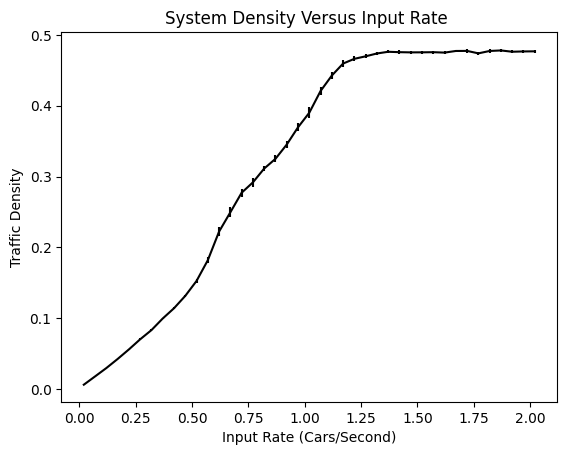

In [34]:
plt.errorbar(netflow_values,simulated_density,simualted_density_conf_int, color = "black")
plt.title("System Density Versus Input Rate ")
plt.xlabel("Input Rate (Cars/Second)")
plt.ylabel("Traffic Density")
plt.show()


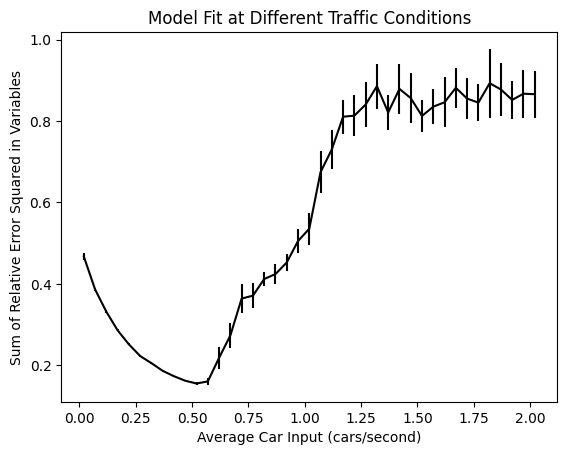

In [35]:
plt.errorbar(netflow_values[0:len(results)],results,conf_int, color = "black")
plt.title("Model Fit at Different Traffic Conditions")
plt.xlabel("Average Car Input (cars/second)")
plt.ylabel("Sum of Relative Error Squared in Variables")

plt.show()



In [36]:
sim = road_system_params.TrafficSystemParameterised()
sim.build_network(edges, nodes, relative_arrival_rates, netflow_rate = 2, dpi = 200)
cycle_offsets  = {
    8: 0,
    5: 0,
    6: 18,
    4: 18,
}
for node, offset in cycle_offsets.items():
    sim.traffic_grid.nodes[node]["node"].counter += offset
plt.close()

/Users/gordonma/PycharmProjects/pythonProject1/road_system_params.py:113: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.axes.plot([row[0], row[2]], [row[1], row[3]], color="black", zorder = 1)


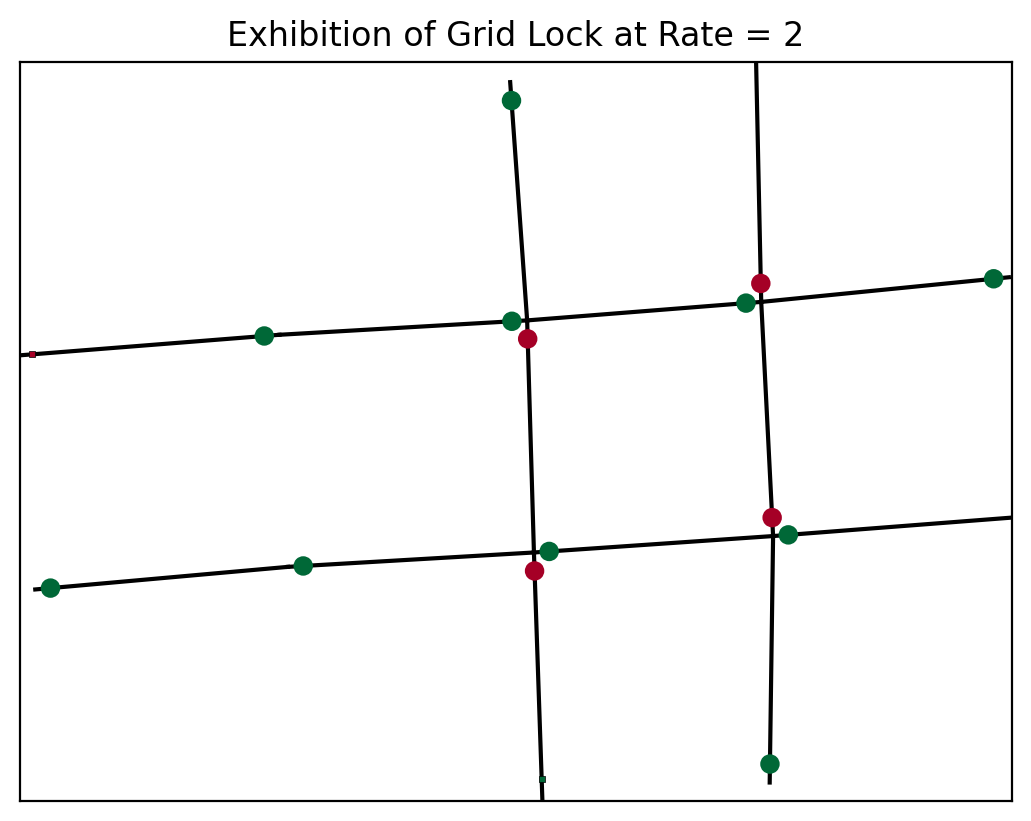

In [37]:
for __ in range(1):
    sim.update()
sim.draw("Exhibition of Grid Lock at Rate = 2")
sim.figure

# Extra Code used for data in Step 4

This notebook contained a few resources that I didn't want to pickle, hence they're done here

In [38]:
def real_flow_rate(sim, cut_off_time):
    """
    Returns the real inflow and outflow rate through the system
    
    return:
        inflow_rate : float
        outflow_rate: float
    """
    cars_out = 0
    for node in sim.outflows:
        cars_out += (len([x for x in node.pool if x.entranceTime > cut_off_time]))
    outflow_rate = cars_out / (sim.time - cut_off_time)
    #Cars out + cars in system = how many cars went into the system
    #Assume sim.time >> cut_off_time so no vehicles from before cutoff is in the system
    inflow_rate = (cars_out + sim.cars_in_system) / (sim.time - cut_off_time)
    return(inflow_rate,outflow_rate)



In [40]:
import scipy.stats as sts
netflow_values = np.linspace(0.02,2.02,41)
results = []
conf_int = []
simulated_density = []
simualted_density_conf_int = []
avg_inflows = []
avg_outflows = []
road_wise_data = []
trials = 5
progress_bar = tqdm(total=len(netflow_values)*trials)
for netflow_rate in netflow_values:
    simulation_results_per_netflow_rate = []
    trial_average = []
    complete_dataframes =[]
    avg_density = []
    avg_inflow = []
    avg_outflow = []
    sim.figure.clf()
    for __ in range(trials):
        progress_bar.update(1)
        try:
            out,sim,trial_result = differences_from_measurement(netflow_rate,
                                                                road_system_params.TrafficSystemParameterised(),
                                                                edges, 
                                                                nodes, 
                                                                relative_arrival_rates)
            inflow, outflow = real_flow_rate(sim, 600)
            avg_density.append(np.mean(sim.density))
            avg_inflow.append(inflow)
            avg_outflow.append(outflow)
            trial_average.append(out)
            complete_dataframes.append(trial_result)
            plt.close()
        except Exception:
            print(f"Error on rate = {netflow_rate}, trial = {__}")
    avg_inflows.append(np.mean(avg_inflow))
    avg_outflows.append(np.mean(avg_outflow))
    road_wise_data.append(complete_dataframes)
    simulated_density.append(np.mean(avg_density))
    simualted_density_conf_int.append(sts.sem(avg_density)*1.96)
    conf_int.append(sts.sem(trial_average)*1.96)
    results.append(np.mean(trial_average))


100%|██████████| 205/205 [39:28<00:00, 14.49s/it]

In [41]:
with open("data/optimal_network_flow_ising_baseline", "wb") as fp:   #Pickling
    pickle.dump([netflow_values,simulated_density,
                      simualted_density_conf_int,avg_inflows,avg_outflows, road_wise_data], fp)
    

In [42]:
np.round(transmatrix,3)

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.217, 0.   , 0.   , 0.   , 0.237, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.154, 0.   , 0.   , 0.284, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.192, 0.   , 0.   , 0.   , 0.   , 0.366, 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.437, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.117, 0.   , 0.437, 0.   , 0.   , 0.

In [43]:
with open("data/optimal_network_flow", "rb") as fp:   #Unpickling
    netflow_values,results, conf_int, simulated_density,simualted_density_conf_int,road_wise_data = pickle.load(fp)

In [44]:
transition_rate = 1.5 # ~1.5 cars per second
trans_norm = transmatrix / (transmatrix.sum(axis = 0) + 1e-15)
trans_norm =  (trans_norm * transition_rate/30 + np.identity(14)* (30- transition_rate)/30)
trans_norm = trans_norm / (trans_norm.sum(axis = 0) + 1e-15)
input_array = np.append(normalized_array.sum(axis = 0),(np.zeros(10)))
markov_matrix = np.insert(trans_norm,0,input_array, axis = 1)
markov_matrix = np.insert(markov_matrix, 0, np.zeros(15), axis = 0)


In [45]:
with open("data/markov_matrix_1.5", "wb") as fp:   #Pickling
    pickle.dump(markov_matrix, fp)


In [46]:
netflow_values = np.linspace(0.02,2.02,41)
system_density = []
out_cars = []
for input_rate in netflow_values:
    inflow_array = np.append([input_rate/30], np.zeros(14))
    current_array = inflow_array
    for __ in range(4000):
        current_array = np.dot(markov_matrix,current_array) + inflow_array
    out_cars.append(np.sum(current_array[-4:] * 30))
    system_density.append(np.sum(current_array[1:-4]) / len(current_array[1:-4]))


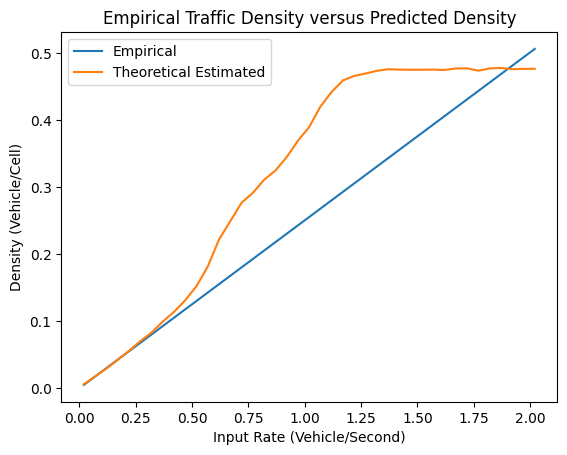

In [47]:
plt.plot(netflow_values,system_density, label = "Empirical")
plt.plot(netflow_values,simulated_density, label = "Theoretical Estimated")
plt.xlabel("Input Rate (Vehicle/Second)")
plt.ylabel("Density (Vehicle/Cell)")
plt.title("Empirical Traffic Density versus Predicted Density")
plt.legend()
plt.show()

In [48]:
np.mean([road.length for road in sim.roads])

np.float64(36.5)